In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/CS525/yelp_compressed_reviews.pkl")
df.head()

,business_id,stars,review_count,visits,visits_normalized,label,reviews_concatenated
0,MTSW4McQd7CbVtyjqoe9mw,4.0,80,335,27.916667,1,This is nice little Chinese bakery in the hear...
1,0bPLkL0QhhPO5kt1_EXmNQ,4.5,100,264,22.000000,1,The worst Chicken Parm. Sandwich I've ever eat...
2,MUTTqe8uqyMdBl186RmNeA,4.0,245,172,34.400000,1,Stopped in to check out this new spot around t...
3,ROeacJQwBeh05Rqg7F6TCg,4.5,205,221,24.555556,1,"This place is fantastic! Delicious, simple, h..."
4,9OG5YkX1g2GReZM0AskizA,2.5,339,508,42.333333,1,Great bar Happy Hour 4-7 every day. Wine & Dra...


In [ ]:
subset = df[['reviews_concatenated','label']].sample(n=10000, random_state=8)
subset.head()

,reviews_concatenated,label
19593,I stopped into Brown St. today. What a great p...,1
14702,Consider myself a foodie within stl and was ex...,1
15150,Wonderful revisit. Food and drinks came prompt...,0
26490,"Wow, this is Italian baby!\n\nDwelling in Cent...",0
14862,NO. JUST. NO.\nOne of my dearest friends wante...,0


In [ ]:
X,y = subset['reviews_concatenated'].values, subset['label'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (7500,)
shape of test data is (2500,)


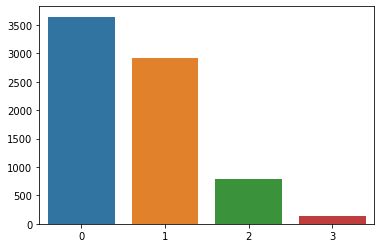

In [ ]:
pd.Series(y_train).value_counts()
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([0,1,2,3]),y=dd.values)
plt.show()

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:len(word_list)]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test), onehot_dict

In [ ]:
nltk.download('stopwords')
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-7-5a0f86673dc7>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test), onehot_dict


Length of vocabulary is 356671


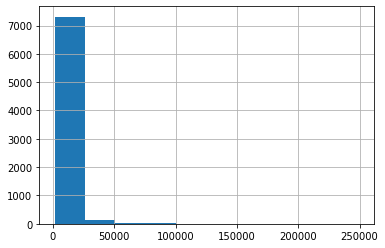

count      7500.000000
mean       6484.489067
std        9174.371240
min        1307.000000
25%        2487.000000
50%        3880.000000
75%        6961.500000
max      249442.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


In [ ]:
class PopularityRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(PopularityRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
          # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

        # Output layer
        #self.sig = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=4)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embeddings and LSTM output
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # Softmax function
        softmax_out = F.softmax(out, dim=1)
        argmax_out = torch.argmax(softmax_out, dim=1)
        argmax_out = argmax_out.view(batch_size, -1)
        argmax_out = argmax_out[:, -1] # Get last batch of labels

        # Reshape to be batch_size first
        softmax_out = softmax_out.view(batch_size, -1)
        softmax_out = softmax_out[:, -1] # Get last batch of labels
        
        # return last sigmoid output and hidden state
        return argmax_out, softmax_out, hidden

    def init_hidden(self, batch_size):
          ''' Initializes hidden state '''
          # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
          # initialized to zero, for hidden state and cell state of LSTM
          h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
          c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
          hidden = (h0,c0)
          return hidden


      

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 4
hidden_dim = 256


model = PopularityRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

print(model)

PopularityRNN(
  (embedding): Embedding(356672, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (softmax): Softmax(dim=4)
)


In [ ]:
# loss and optimization functions
learning_rate=0.001


#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs, labels 
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output, output_probs, h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output_probs.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs, labels

            output, output_probs, val_h = model(inputs, val_h)
            val_loss = criterion(output_probs.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 147.73298583984376 val_loss : 147.63971420288087
train_accuracy : 34.346666666666664 val_accuracy : 48.6
Validation loss decreased (inf --> 147.639714).  Saving model ...
Epoch 2
train_loss : 147.7419452412923 val_loss : 147.6396812438965
train_accuracy : 40.32 val_accuracy : 38.92
Validation loss decreased (147.639714 --> 147.639681).  Saving model ...
Epoch 3
train_loss : 147.74561620076497 val_loss : 147.63955047607422
train_accuracy : 46.72 val_accuracy : 48.6
Validation loss decreased (147.639681 --> 147.639550).  Saving model ...
Epoch 4
train_loss : 147.59540664672852 val_loss : 147.55711791992186
train_accuracy : 33.33333333333333 val_accuracy : 15.64
Validation loss decreased (147.639550 --> 147.557118).  Saving model ...
Epoch 5
train_loss : 147.21895634969076 val_loss : 147.54643112182617
train_accuracy : 14.16 val_accuracy : 2.6
Validation loss decreased (147.557118 --> 147.546431).  Saving model ...


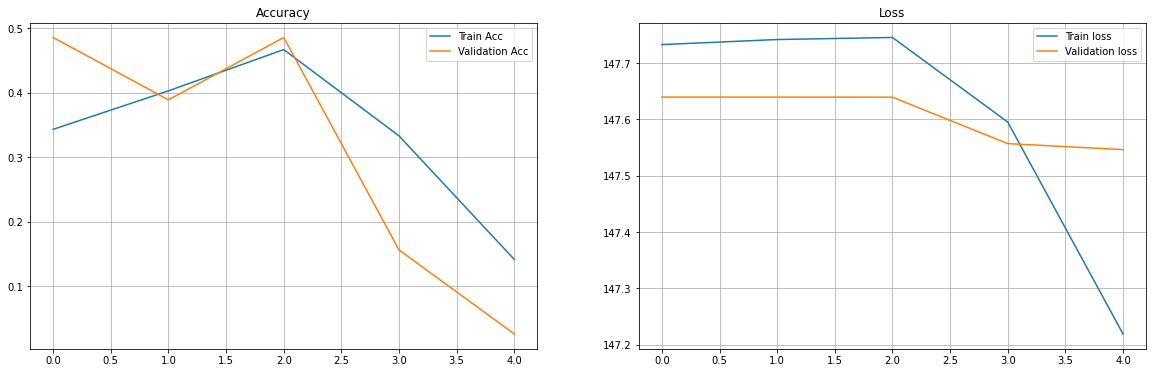

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()